# Preprocesamiento y análisis de features

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from gensim.models import Word2Vec
from sklearn.feature_selection import SelectKBest, chi2

import pickle
data = pickle.load(open("saved_feats/data", "rb"))

# FORMATO DE PLOTS
plt.style.use('bmh')

## Bag of Words

Primero establecemos la variable sentimiento según el rating, siendo 1-2 negativo, 3 neutro y 4-5 positivo

In [2]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

data_clean=data.dropna(axis='index', how='any')

# Add sentiments to the data
data_text = data_clean["reviews.text"].to_numpy()
data_sentiment = data_clean["reviews.rating"].apply(sentiments).to_numpy()

Convertimos el contenido en vectores

In [3]:
BoW = CountVectorizer(stop_words='english', ngram_range=(1,1))
data_text_bow = BoW.fit_transform(data_text)

print('shape of data_text_bow is {}'.format(data_text_bow.get_shape()))

shape of data_text_bow is (27212, 11549)


## TFIDF

Suprimimos la redundancia que pueden ocasionar palabras que tienen poco significado y que son las más repetidas en textos largos

In [4]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True, sublinear_tf=False)
data_text_tfidf = tfidf.fit_transform(data_text_bow)

print('shape of data_text_tfidf is {}'.format(data_text_tfidf.get_shape()))

shape of data_text_tfidf is (27212, 11549)


## Selección de mejores features

In [5]:
# seleccionamos las N mejores features según su relación con el outcome
best = SelectKBest(chi2, k=5000)
data_text_kbest = best.fit_transform(data_text_tfidf, data_sentiment)

print('shape of data_text_kbest is {}'.format(data_text_kbest.get_shape()))

shape of data_text_kbest is (27212, 5000)


(11549,)


(array([ 584.,  189.,  100.,   76.,   63.,   41.,   60.,   53.,   43.,
          41.,   33.,   47.,   29.,   24.,   42.,   26.,   30.,   30.,
          26.,   38.,   22.,   17.,   25.,   22.,   15.,   28.,   15.,
          23.,   21.,   24.,   24.,   21.,   16.,   32.,   28.,   22.,
          23.,   23.,   23.,   18.,   13.,   22.,   24.,   22.,   20.,
          23.,   21.,   19.,   22.,   21.,   18.,   26.,   23.,   26.,
          20.,   30.,   33.,   14.,   29.,   31.,   25.,   23.,   28.,
          25.,   37.,   29.,   24.,   39.,   38.,   35.,   25.,   45.,
          38.,   39.,   48.,   36.,   36.,   44.,   48.,   65.,   48.,
          51.,   55.,   65.,   80.,   75.,   88.,   93.,  112.,  114.,
         134.,  166.,  183.,  210.,  286.,  367.,  579., 1212., 2711.,
        1714.]),
 array([2.86448036e-19, 9.98892059e-03, 1.99778412e-02, 2.99667618e-02,
        3.99556823e-02, 4.99446029e-02, 5.99335235e-02, 6.99224441e-02,
        7.99113647e-02, 8.99002853e-02, 9.98892059e-02, 1.

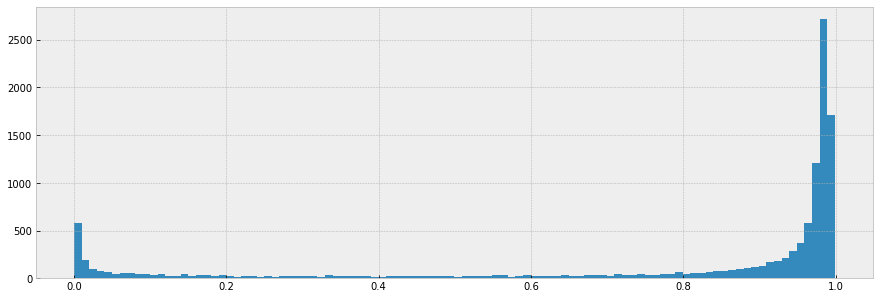

In [6]:
# Queremos ver las features mejor correladas con la variable outcome. Con el BestK hemos seleccionado 1000 de las 11000,
# Con el histograma de pvalues vemos que salvo las 2000 primeras (p-value < 0.05 => no estan correladas), el resto son buenas
# y están correladas con el outcome
print(best.pvalues_.shape)

plt.figure(figsize=(15, 5))
plt.hist(best.pvalues_[best.scores_ <= 100], 100)

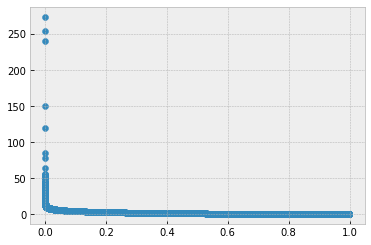

In [7]:
plt.scatter(best.pvalues_,best.scores_)

In [ ]:
df_data_trans = pd.DataFrame(data_text_tfidf.toarray())
# obtenemos la matriz de correlación para ver si hay features que sean redundantes
corr = df_data_trans.corr()
# vemos los límites de los valores de correlación para luego mostrar el heatmap con mas contraste
plt.hist(corr)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

# vemos que las correlaciones entre features son muy bajas. Por tanto, no tenemos que preocuparnos por eso
sns.heatmap(corr, cmap="YlGnBu", linecolor='white',
            linewidth=0, vmin=-0, vmax=0.1)

### Almacenamiento de features

In [8]:
pickle.dump(data_text_tfidf, open("saved_feats/data_text_tfidf", "wb"))
pickle.dump(data_sentiment, open("saved_feats/data_sentiment", "wb"))